Stream inference with a machine vision camera

# Import

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from skimage.measure import label, regionprops

from fiducial_detect.data import *
from fiducial_detect.models import *

In [2]:
sys.path.append('../multi_pyspin/')

In [3]:
import multi_pyspin

19061245 - connected


# Config

In [4]:
file_yaml = Path('cam.yaml')

In [5]:
file_model = Path('training/attempt_2/checkpoints/best.pth')

In [6]:
sz = (512, 384)

# Test

Setup camera

In [7]:
serial = multi_pyspin.setup(file_yaml.as_posix())

19061245 - setting up...
19061245 - executing: "UserSetSelector.SetValue(PySpin.UserSetDefault_Default)"
19061245 - executing: "UserSetLoad.Execute()"
19061245 - executing: "LineSelector.SetValue(PySpin.LineSelector_Line2)"
19061245 - executing: "V3_3Enable.SetValue(True)"
19061245 - executing: "AcquisitionFrameRateEnable.SetValue(True)"
19061245 - executing: "AcquisitionFrameRate.SetValue(5)"
19061245 - executing: "ExposureMode.SetValue(PySpin.ExposureMode_Timed)"
19061245 - executing: "ExposureAuto.SetValue(PySpin.ExposureAuto_Off)"
19061245 - executing: "ExposureTime.SetValue(60000)"
19061245 - executing: "GainSelector.SetValue(PySpin.GainSelector_All)"
19061245 - executing: "GainAuto.SetValue(PySpin.GainAuto_Off)"
19061245 - executing: "Gain.SetValue(6)"
19061245 - executing: "BlackLevelSelector.SetValue(PySpin.BlackLevelSelector_All)"
19061245 - executing: "BlackLevel.SetValue(0)"
19061245 - executing: "GammaEnable.SetValue(False)"
19061245 - executing: "PixelFormat.SetValue(PySpi

In [8]:
multi_pyspin.node_cmd(serial, 'TLStream.StreamBufferHandlingMode', 'SetValue', 'RW', 'PySpin.StreamBufferHandlingMode_NewestOnly')
multi_pyspin.node_cmd(serial, 'AcquisitionMode', 'SetValue', 'RW', 'PySpin.AcquisitionMode_Continuous')

19061245 - executing: "TLStream.StreamBufferHandlingMode.SetValue(PySpin.StreamBufferHandlingMode_NewestOnly)"
19061245 - executing: "AcquisitionMode.SetValue(PySpin.AcquisitionMode_Continuous)"


In [9]:
multi_pyspin.start_acquisition(serial)

Load model

In [10]:
# Model
in_channels  = 1
out_channels = 5
layout_encoder = [[[48,5,2,2]],
                  [[48,3,1,1],[48,3,2,1]],
                  [[60,3,1,1],[60,3,2,1]],
                  [[72,3,1,1],[144,3,2,1]]]
model = UNET(get_encoder(in_channels, layout_encoder), out_channels)
model = model.to('cuda')
model.load_state_dict(torch.load(file_model)['model'])
model = model.eval()

Stream images

In [11]:
def _get_img():
    return multi_pyspin.get_image(serial)['image'].GetNDArray() # Might result in mem leak

In [12]:
def _format_img(img):
    img = img/(2**16-1) # 16 bit unsigned
    img = np.array(Image.fromarray(img).resize(sz, resample=Image.BILINEAR))
    img = normalize(img, (0, 1), (-1, 1))
    return img

In [13]:
def _get_mask(img):
    # Tensorify image and send to device
    img = torch.tensor(img)[None, None, :, :]
    img = img.to('cuda')
    # Do inference
    model.eval()
    with torch.no_grad():
        mask = model(img)
        mask = mask.argmax(dim=1)
        mask = mask[0, :, :].cpu().detach().numpy()
    return mask

<IPython.core.display.Javascript object>


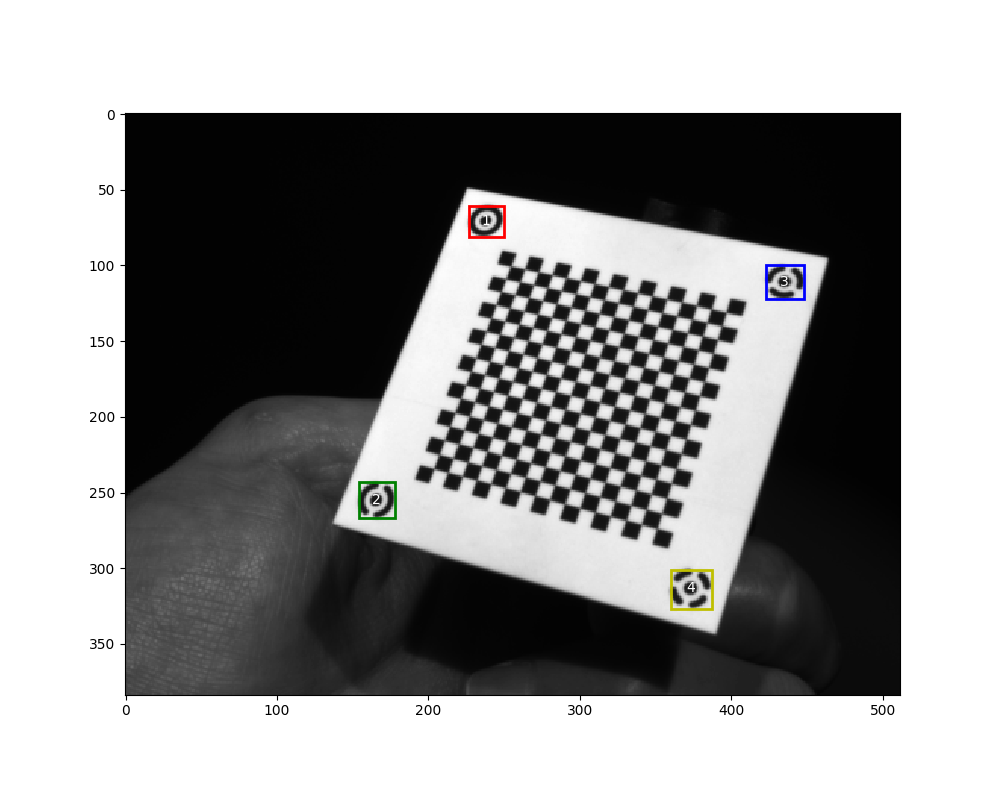

In [14]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(10, 8))
cs = ['r', 'g', 'b', 'y']
texts = [ax.text(0, 0, str(idx+1),
                 c='white',
                 horizontalalignment='center',
                 verticalalignment='center') for idx in range(4)]
rects = [ax.add_patch(plt.Rectangle((0, 0), 0, 0,
                                    fill=False,
                                    color=cs[idx],
                                    linewidth=2)) for idx in range(4)]
imshow = ax.imshow(-np.ones((sz[1], sz[0])), cmap='gray', vmin=-1, vmax=1)
fig.canvas.draw()
try:
    while True:
        # Get mask
        img = _get_img()
        img = _format_img(img)
        mask = _get_mask(img)
        
        # Plot
        plots = []
        for idx in range(4):
            l = label(mask == (idx+1))
            regions = regionprops(l)
            if len(regions) > 0:
                region = regions[np.argmax([r.area for r in regions])]
                texts[idx].set_position((region.centroid[1], region.centroid[0]))
                rects[idx].set_bounds(region.bbox[1], region.bbox[0],
                                      region.bbox[3]-region.bbox[1],
                                      region.bbox[2]-region.bbox[0])
            else:
                texts[idx].set_position((0, 0))
                rects[idx].set_bounds(0,0,0,0)
        imshow.set_data(img)
        fig.canvas.draw()
        
except KeyboardInterrupt:
    pass

%matplotlib inline

Cleanup

In [15]:
multi_pyspin.end_acquisition(serial)
multi_pyspin.deinit(serial)